## Pip Installation

In [1]:
!pip install sage_data_client
!pip install qdrant_client # Vector Database
!pip install sentence-transformers
!pip install fastembed
!pip install matplotlib

zsh:1: /Users/eugenevuong/Documents/Programming/QdrantSageSearch/.venv/bin/pip: bad interpreter: /Users/eugenevuong/Documents/Programming/test2/.venv/bin/python: no such file or directory
  Using cached sage_data_client-0.9.0-py3-none-any.whl.metadata (4.0 kB)
Using cached sage_data_client-0.9.0-py3-none-any.whl (6.4 kB)

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: /Users/eugenevuong/anaconda3/bin/python3 -m pip install --upgrade pip
zsh:1: /Users/eugenevuong/Documents/Programming/QdrantSageSearch/.venv/bin/pip: bad interpreter: /Users/eugenevuong/Documents/Programming/test2/.venv/bin/python: no such file or directory
  Using cached qdrant_client-1.13.2-py3-none-any.whl.metadata (10 kB)
  Using cached grpcio-1.70.0-cp311-cp311-macosx_10_14_universal2.whl.metadata (3.9 kB)
  Using cached portalocker-2.10.1-py3-none-any.whl.metadata (8.5 kB)
  Using cached protobuf-5.29.3-cp38-abi3-macosx_10_9_universal2.whl.metadata (592 bytes)
  Using cached h2-4.2

## Importing/Preprocessing Dataframe


In [2]:
import sage_data_client
df = sage_data_client.load("./test-run/data.ndjson")

column_order = ["upload", "base64_image", "description", "text_embedding", "image_embedding"]

# Reorder the DataFrame
df = df.pivot(index="timestamp", columns="name", values="value")[column_order]

# Reset index if needed
df = df.reset_index()

# Display the updated DataFrame
df

name,timestamp,upload,base64_image,description,text_embedding,image_embedding
0,2025-02-07 12:36:11.756872+00:00,/Users/eugenevuong/Documents/Programming/test2...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,The image depicts a man holding a cell phone i...,"[-0.016299951821565628, -0.055472634732723236,...","[0.8459229469299316, 0.3277042806148529, 0.504..."
1,2025-02-07 12:36:20.961314+00:00,/Users/eugenevuong/Documents/Programming/test2...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,The image depicts a man holding a book in fron...,"[-0.02855149656534195, -0.09510558098554611, 0...","[0.2142753303050995, -0.05849756300449371, 0.4..."
2,2025-02-07 12:36:27.597312+00:00,/Users/eugenevuong/Documents/Programming/test2...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...,The image depicts a man holding a white mug in...,"[0.00655781477689743, -0.041473403573036194, 0...","[0.7605889439582825, 0.37348443269729614, 0.67..."


## Import Dataframe to Qdrant

In [3]:
from qdrant_client import QdrantClient
from qdrant_client.http import models
from fastembed import TextEmbedding
from sentence_transformers import SentenceTransformer
from PIL import Image
import base64
from io import BytesIO
from IPython.display import display
import matplotlib.pyplot as plt

client = QdrantClient(url="http://localhost:6333")

client.recreate_collection(
    collection_name="my_collection",
    vectors_config={"image": models.VectorParams(size=768, distance=models.Distance.COSINE),
                    "description": models.VectorParams(size=1024, distance=models.Distance.COSINE)
                    }
)

for i, row in df.iterrows():
    payload={"upload": row["upload"], "base64_image": row["base64_image"], "description": row["description"]}
    client.upsert(
                    collection_name="my_collection",
                    wait=True,
                    points=[models.PointStruct(id=i, payload=payload, vector={"image": eval(row["image_embedding"]), "description": eval(row["text_embedding"])})]
                )


/Users/eugenevuong/Documents/Programming/QdrantSageSearch/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/yx/468f69wj7996jbkrg8w4nynh0000gn/T/ipykernel_50471/2684856387.py:13: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


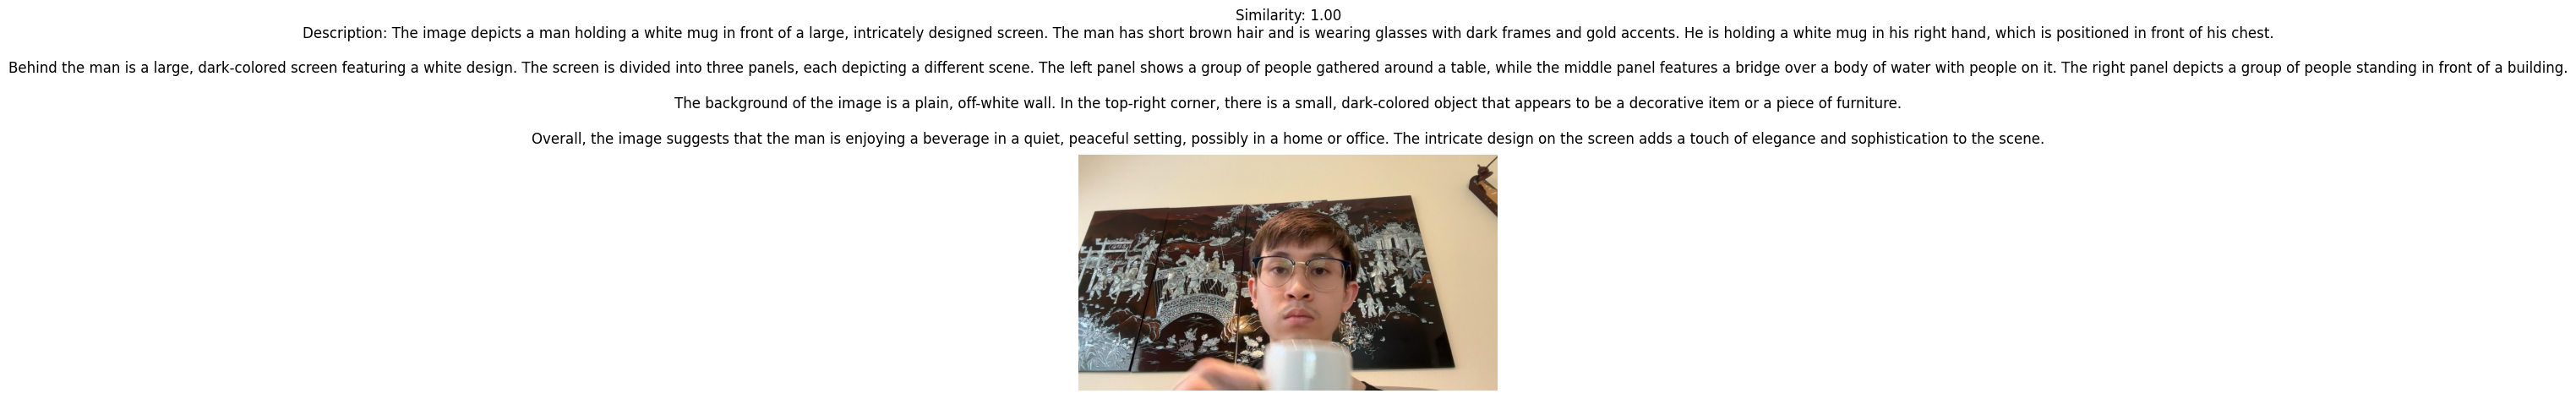

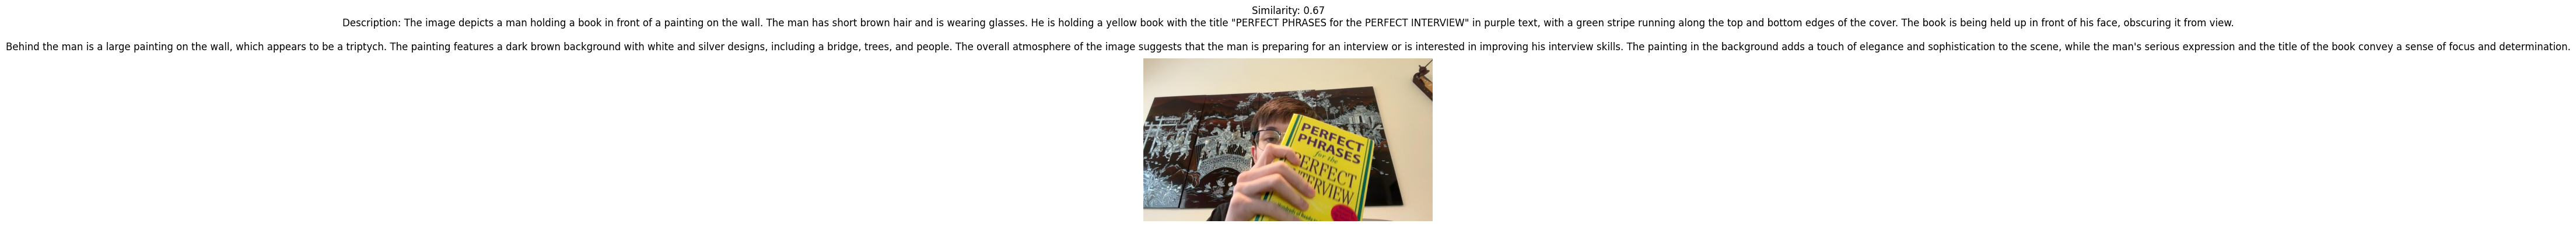

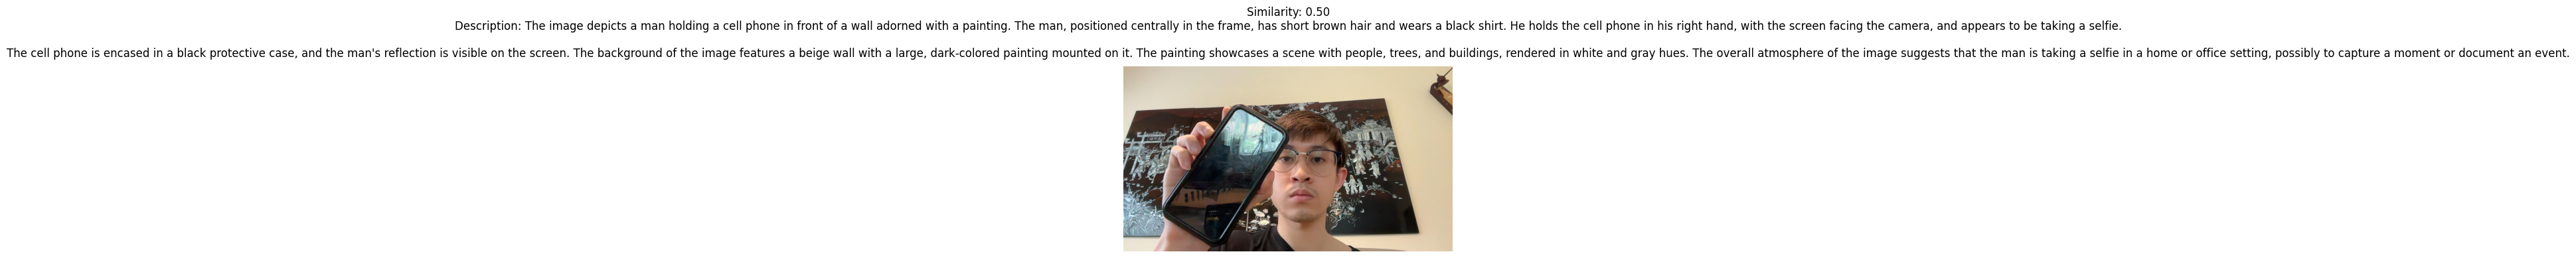

In [4]:
query = "Person with cup"

clip = SentenceTransformer('clip-ViT-L-14')
text_embed = TextEmbedding(model_name="snowflake/snowflake-arctic-embed-l")

image_embedding = clip.encode(query).tolist()
text_embeddings = text_embed.embed([query])
text_embeddings = (list(text_embeddings)[0]).tolist()

def decode_base64_image(base64_str):
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    return image

# Hydrid Search
image_hits = client.query_points(
        collection_name="my_collection",
        prefetch=[
            models.Prefetch(
                query=image_embedding,
                using="image",
                limit=20,
            ),
            models.Prefetch(
                query=text_embeddings,
                using="description",
                limit=20,
            ),
        ],
        query=models.FusionQuery(fusion=models.Fusion.RRF),
    )

hits = image_hits.points
# print(len(image_hits))
# Display search results
for hit in hits:
    image_data = hit.payload["base64_image"]
    plt.imshow(decode_base64_image(image_data))
    plt.axis('off')  # Hide axes
    plt.title(f"Similarity: {hit.score:.2f}\nDescription: {hit.payload['description']}", fontsize=12, pad=10)
    plt.show()